Training Samples: (400, 2), Test Samples: (100, 2)
Test Loss (MSE): 9300.412109375


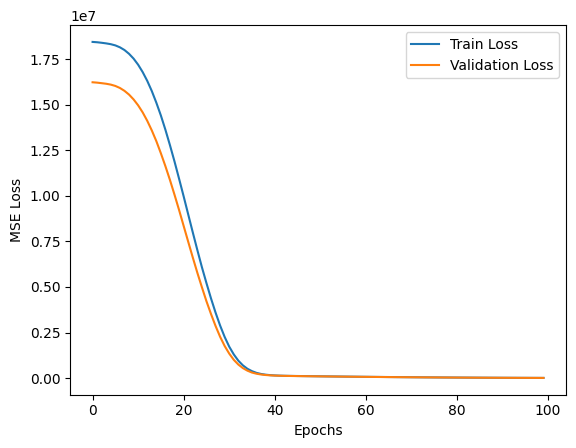

In [3]:
# Importing libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Generate synthetic data for house prices
np.random.seed(42)
num_samples = 500
X = np.random.rand(num_samples, 2) * 100
y = 50 * X[:, 0] + 30 * X[:, 1] + np.random.randn(num_samples) * 10
y = y.reshape(-1, 1)

# Split into training and test sets
train_size = int(0.8 * num_samples)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
print(f"Training Samples: {X_train.shape}, Test Samples: {X_test.shape}")

# Define the custom LoRA Layer
class LoRALayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, rank=2, alpha=1.0):
        super(LoRALayer, self).__init__()
        self.rank = rank
        self.alpha = alpha

        # Main frozen weight matrix
        self.W = self.add_weight(shape=(input_dim, output_dim), initializer="random_normal", trainable=False)

        # LoRA trainable low-rank matrices
        self.A = self.add_weight(shape=(input_dim, rank), initializer="random_normal", trainable=True)
        self.B = self.add_weight(shape=(rank, output_dim), initializer="random_normal", trainable=True)

    def call(self, inputs):
        lora_update = tf.matmul(inputs, self.A)
        lora_update = tf.matmul(lora_update, self.B) * self.alpha
        return tf.matmul(inputs, self.W) + lora_update

# Define the model with the LoRA layer
input_dim = X_train.shape[1]
output_dim = 1
inputs = keras.Input(shape=(input_dim,))
x = LoRALayer(input_dim, 16, rank=2, alpha=1.0)(inputs)
x = layers.ReLU()(x)
x = layers.Dense(1)(x)
model = keras.Model(inputs, x)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=0)

# Evaluate on test data
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss}")

# Plot training loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# 4-bit Quantization function (for QLoRA)
def quantize_4bit(weights):
    min_w, max_w = np.min(weights), np.max(weights)
    scale = (max_w - min_w) / 15
    quantized = np.round((weights - min_w) / scale).astype(np.int8)
    return quantized, min_w, scale